<a href="https://colab.research.google.com/github/GiovaniValdrighi/school_eval_ethical/blob/main/notebooks/modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyImpetus

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from time import time

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, balanced_accuracy_score, confusion_matrix, brier_score_loss
from PyImpetus import PPIMBC
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Data preparation

**IMPORTANT CELL, CONFIGURE TO USE NOTEBOOK**

**TO HAVE DATA AND TRAINED MODELS, COPY ALL THE DATA FROM THIS LINK TO YOUR DRIVE (PATH_ROOT):**

https://drive.google.com/drive/folders/10rK8yaRjpWVcUxEOyt1Wxe71sSUbOLHS?usp=sharing

In [ ]:
PATH_ROOT = "/content/drive/MyDrive/courses/ai_ethics/school_eval/"
TRAIN_MODELS = False # use False for not training models that have long computational cost

In [ ]:
df = pd.read_csv(PATH_ROOT + "data/microdados_saeb_2019/clean_schools_v2.csv")
df.head()

### Converting columns values

In [ ]:
n_unique = df.nunique()
only_one_value = n_unique[n_unique == 1].index.values.tolist()
too_many_values = n_unique[n_unique > 30].index.values.tolist()
only_one_value + too_many_values

['TX_RESP_Q037',
 'ID_MUNICIPIO',
 'PC_FORMACAO_DOCENTE_FINAL',
 'NU_MATRICULADOS_CENSO_9EF',
 'NU_PRESENTES_9EF',
 'TAXA_PARTICIPACAO_9EF',
 'TX_RESP_Q010',
 'TX_RESP_Q017',
 'TX_RESP_Q021',
 'TX_RESP_Q067',
 'MEDIA']

In [ ]:
# drop column with unique value or too many values
df = df.drop(columns = ["TX_RESP_Q037", "ID_MUNICIPIO"])

Converting column coded values to named values.

In [ ]:
id_regiao = {1 : "norte", 2: "nordeste", 3:"sudeste", 4:"sul", 5:"centro-oeste"}
id_uf = {11: 'RO',
 12: 'AC',
 13: 'AM',
 14: 'RR',
 15: 'PA',
 16: 'AP',
 17: 'TO',
 21: 'MA',
 22: 'PI',
 23: 'CE',
 24: 'RN',
 25: 'PB',
 26: 'PE',
 27: 'AL',
 28: 'SE',
 29: 'BA',
 31: 'MG',
 32: 'ES',
 33: 'RJ',
 35: 'SP',
 41: 'PR',
 42: 'SC',
 43: 'RS',
 50: 'MS',
 51: 'MT',
 52: 'GO',
 53: 'DF'}
id_area = {1: "capital", 2:"interior"}
id_localizacao = {1 : "urbana", 2:"rural"}
df["ID_REGIAO"] = df["ID_REGIAO"].map(id_regiao)
df["ID_UF"] = df["ID_UF"].map(id_uf)
df["ID_AREA"] = df["ID_AREA"].map(id_area)
df["ID_LOCALIZACAO"] = df["ID_LOCALIZACAO"].map(id_localizacao)
df["NIVEL_SOCIO_ECONOMICO"] = df["NIVEL_SOCIO_ECONOMICO"].apply(lambda x : x.replace("í", "i").replace(" ", "-").lower())

Convert binary columns to values 1 and 0.

In [ ]:
binary_features = (
    [f"TX_RESP_Q0{i}" for i in range(34, 41)] +
    [f"TX_RESP_Q0{i}" for i in range(57, 67)] +
    [f"TX_RESP_Q0{i}" for i in range(76, 100)] +
    [f"TX_RESP_Q{i}" for i in range(100, 103)] +
    [f"TX_RESP_Q{i}" for i in range(109, 118)] +
    ["TX_RESP_Q129", "TX_RESP_Q131", "TX_RESP_Q133"] +
    [f"TX_RESP_Q{i}" for i in range(135, 147)] +
    [f"TX_RESP_Q{i}" for i in range(156, 159)] +
    [f"TX_RESP_Q{i}" for i in range(166, 199)] +
    [f"TX_RESP_Q{i}" for i in range(206, 252)]
)
binary_features = [feat for feat in binary_features if feat in df.columns]


binary_invalid = {"A" : 1, "B" : 0, "invalido" : 0}
binary = {"A" : 1, "B": 0}
for col in binary_features:
  if df[col].isin(["invalido"]).max():
    df[col] = df[col].map(binary_invalid)
  else:
    df[col] = df[col].map(binary)

# fixing some categoric features
df["TX_RESP_Q067"] = df["TX_RESP_Q067"].apply(lambda x : 0 if x=="invalido" else x)
df["TX_RESP_Q067"] = df["TX_RESP_Q067"].astype("float")
for i in range(119, 125):
  df[f"TX_RESP_Q{i}"] = df[f"TX_RESP_Q{i}"].apply(lambda x : 0 if x=="invalido" else x)
  df[f"TX_RESP_Q{i}"] = df[f"TX_RESP_Q{i}"].astype("float")


### Transform score to binary class

<ipython-input-82-596c1c3a2ca9>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Socioeconomic index"] = df.NIVEL_SOCIO_ECONOMICO.apply(lambda x : {


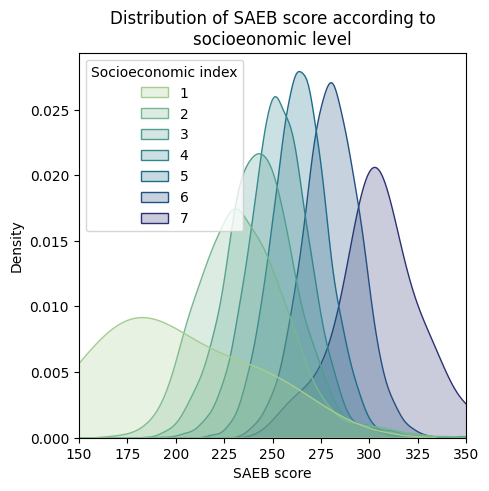

In [ ]:
df["Socioeconomic index"] = df.NIVEL_SOCIO_ECONOMICO.apply(lambda x : {
    "i": 1, "ii" : 2, "iii" : 3, "iv" : 4, "v" : 5,
    "vi" : 6, "vii" : 7
}[x.split("-")[-1]])
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5 , 5))
sns.kdeplot(df, x="MEDIA", hue="Socioeconomic index", fill = True, palette = "crest", common_norm = False, ax = ax)
ax.set_xlabel("SAEB score")
sns.move_legend(ax, "upper left")
ax.set_xlim(150, 350)
ax.set_title("Distribution of SAEB score according to\nsocioeonomic level")
plt.show()

In [ ]:
df = df.iloc[:, :-1]
df["MEDIA"] = (df["MEDIA"] < 250).astype(np.int64)

### Split data

In [ ]:
target = "MEDIA"
num_features = df.select_dtypes("number").columns.tolist()
num_features = [col for col in num_features if not col in binary_features]
cat_features = [col for col in df.columns if not (col in binary_features or col in num_features)]
num_features.remove(target)

In [ ]:
Y = df[target]
X = df.drop(columns = [target])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)

In [ ]:
X_train.to_csv(PATH_ROOT + "data/X_train_clean.csv", index = False)
X_test.to_csv(PATH_ROOT + "data/X_test_clean.csv", index = False)
Y_train.to_csv(PATH_ROOT + "data/Y_train_clean.csv", index = False)
Y_test.to_csv(PATH_ROOT + "data/Y_test_clean.csv", index = False)

In [ ]:
print(X_train.columns)

Index(['ID_REGIAO', 'ID_UF', 'ID_AREA', 'ID_LOCALIZACAO',
       'PC_FORMACAO_DOCENTE_FINAL', 'NIVEL_SOCIO_ECONOMICO',
       'NU_MATRICULADOS_CENSO_9EF', 'NU_PRESENTES_9EF',
       'TAXA_PARTICIPACAO_9EF', 'TX_RESP_Q001',
       ...
       'TX_RESP_Q244', 'TX_RESP_Q245', 'TX_RESP_Q246', 'TX_RESP_Q247',
       'TX_RESP_Q248', 'TX_RESP_Q249', 'TX_RESP_Q250', 'TX_RESP_Q251',
       'TX_RESP_Q252', 'TX_RESP_Q253'],
      dtype='object', length=232)


In [ ]:
X_train = pd.read_csv(PATH_ROOT + "data/X_train_clean.csv")
X_test = pd.read_csv(PATH_ROOT + "data/X_test_clean.csv")
Y_train = pd.read_csv(PATH_ROOT + "data/Y_train_clean.csv")
Y_test = pd.read_csv(PATH_ROOT + "data/Y_test_clean.csv")

## 2. Feature Analysis

In [ ]:
class MyDecorrelator(BaseEstimator, TransformerMixin):

    def __init__(self, threshold):
        self.threshold = threshold
        self.correlated_columns = None

    def fit(self, X, y=None):
        correlated_features = set()
        X = pd.DataFrame(X)
        corr_matrix = X.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > self.threshold: # we are interested in absolute coeff value
                    colname = corr_matrix.columns[i]  # getting the name of column
                    correlated_features.add(colname)
        self.correlated_features = correlated_features
        return self

    def transform(self, X, y=None, **kwargs):
        return (pd.DataFrame(X)).drop(labels=self.correlated_features, axis=1)


def get_pipeline_decorrelate(model = None):
  pipeline = [(
    "preprocess",
    ColumnTransformer([
        ["scaling", StandardScaler(), num_features],
        ["one_hot", OneHotEncoder(sparse_output = False, handle_unknown="ignore"), cat_features]
      ], remainder = "passthrough", verbose_feature_names_out=False)
  ), (
    "descorrelate",
    MyDecorrelator(0.6)
  )]
  pipeline[0][1].set_output(transform = "pandas")
  if model is not None:
    pipeline += [("classifier", model())]
  return Pipeline(pipeline)

In [ ]:
preprocess = get_pipeline_decorrelate()
preprocess.fit(X_train)
x_ = preprocess.transform(X_train)

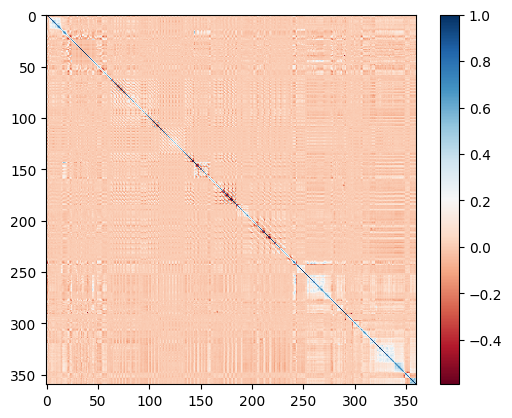

In [ ]:
data_corr = x_.corr()
plt.imshow(data_corr, cmap = "RdBu")
plt.colorbar()
plt.show()

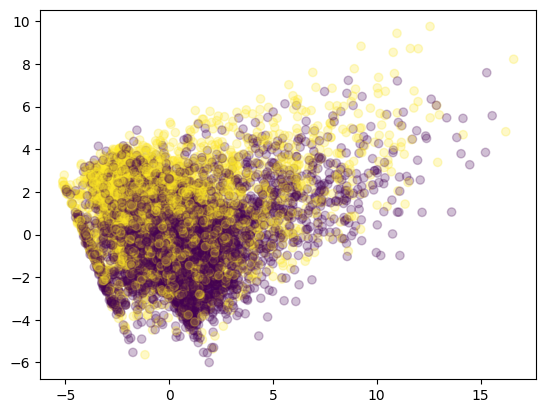

In [ ]:
x_2d = PCA().fit_transform(x_)
plt.scatter(x_2d[:, 0], x_2d[:, 1], c = Y_train.values.ravel(), cmap = "viridis", alpha = 0.25)
plt.show()

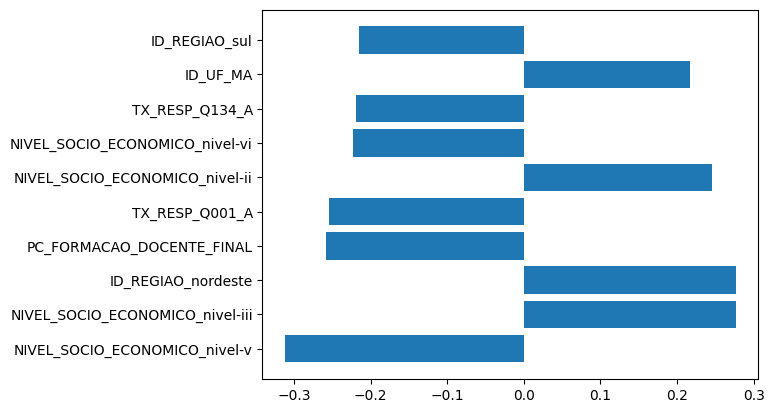

In [ ]:
correlation_with_target = [(col, pearsonr(x_[col], Y_train.values.ravel())[0]) for col in x_.columns]
correlation_with_target.sort(key = lambda x : -abs(x[1]))
correlation_with_target = correlation_with_target[:10]
plt.barh(list(range(10)), [x[1] for x in correlation_with_target])
plt.yticks(list(range(10)), labels = [x[0] for x in correlation_with_target])
plt.show()

In [ ]:
print(f"Fraction of positive samples: {Y_train.values.mean()}")

Fraction of positive samples: 0.3972953216374269


## 3.Models training



In [ ]:
params_space = {}
params_space["knn"] = {
  "classifier__n_neighbors":   [3, 5, 8, 10, 13, 15, 20]
}
params_space["svm"] = {
  "classifier__C" : [0.01, 0.1, 1, 10, 100],
}
params_space["lr"] = {
      "classifier__C" :  [0.01, 0.1, 1, 10, 100],
      "classifier__max_iter" : [1000]
}
params_space["lgbm"] = {
  "classifier__max_depth" : [4, 6, 8],
  "classifier__colsample_bytree" : [0.5, 0.75, 1],
  "classifier__n_estimators" : [10, 15, 20, 50],
  "classifier__lambda_l2" : [0.1, 1, 10, 100],
  "classifier__verbose" : [-1],
}

In [ ]:
classifiers = {
    "knn" : KNeighborsClassifier,
    "svm" : LinearSVC,
    "lr" : LogisticRegression,
    "lgbm": LGBMClassifier,
}

### 3.1 Training without correlated features

In [ ]:
classifiers_fit = {}
if TRAIN_MODELS:
  for name, model in classifiers.items():
    start = time()
    m = get_pipeline_decorrelate(model)
    grid = GridSearchCV(m, params_space[name], scoring = "recall", n_jobs = -1)
    grid.fit(X_train, Y_train)
    pkl.dump(grid, open(PATH_ROOT +"results/" + name + "_grid.pkl", "wb"))
    end = time()
    print(f"Finished {name} in {end - start}")
    classifiers_fit[name] = grid
else:
  for name, model in classifiers.items():
    classifiers_fit[name] = pkl.load(open(PATH_ROOT +"results/" + name + "_grid.pkl", "rb"))

#### Results

In [ ]:
results_df = []
better_names = {
    "lr" : "Logistic",
    "knn" : "K-neighbors",
    "svm" : "Linear SVM",
    "lgbm" : "LGBM"
}
for name, model in classifiers_fit.items():
  Y_pred = model.predict(X_test)
  results_df.append({
      "model" : better_names[name],
      "balanced_accuracy" : balanced_accuracy_score(Y_test, Y_pred),
      "recall" : recall_score(Y_test, Y_pred),
  })

results_df = pd.DataFrame(results_df)
results_df = results_df.iloc[::-1].reset_index(drop = True)

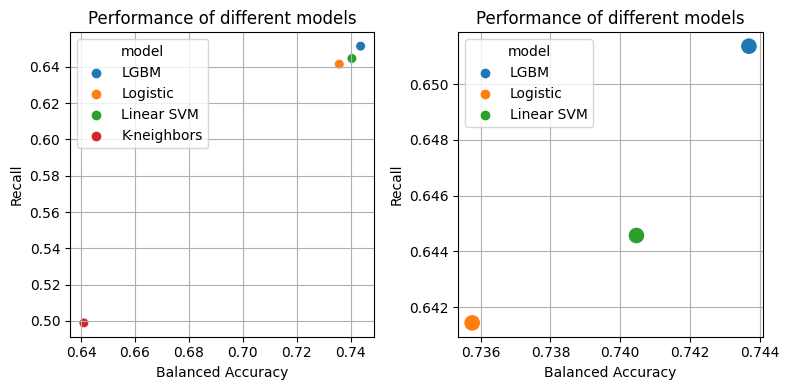

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4))
sns.scatterplot(
    results_df,
    x = "balanced_accuracy",
    y = "recall",
    hue = "model",
    s = 50,
    ax = axs[0]
)
sns.scatterplot(
    results_df.iloc[:-1, :],
    x = "balanced_accuracy",
    y = "recall",
    hue = "model",
    s = 150,
    ax = axs[1]
)
for i in range(2):
  axs[i].set_xlabel("Balanced Accuracy")
  axs[i].set_ylabel("Recall")
  axs[i].set_title("Performance of different models")
  axs[i].grid(True)
plt.tight_layout()

plt.savefig("scatterplot_models_1.pdf")
plt.show()


In [ ]:
for name in classifiers_fit.keys():
  print(name)
  i_best_model = np.argmax(classifiers_fit[name].cv_results_["mean_test_score"])
  best_params = classifiers_fit[name].cv_results_["params"][i_best_model]
  print(best_params)

knn
{'classifier__n_neighbors': 3}
svm
{'classifier__C': 0.1}
lr
{'classifier__C': 1, 'classifier__max_iter': 1000}
lgbm
{'classifier__colsample_bytree': 1, 'classifier__lambda_l2': 0.1, 'classifier__max_depth': 4, 'classifier__n_estimators': 50, 'classifier__verbose': -1}


### 3.2 Models with features with high mutual information

It's necessary to transform categorical columns to numbers to calculate mutual information.

In [ ]:
if TRAIN_MODELS:
  X_train_ordinal = X_train.copy()
  X_test_ordinal = X_test.copy()
  for col in cat_features:
    enc = OrdinalEncoder()
    enc.fit(X_train_ordinal[col].values.reshape(-1, 1))
    X_train_ordinal[col] = enc.fit_transform(X_train_ordinal[col].values.reshape(-1, 1))
    X_test_ordinal[col] = enc.transform(X_test_ordinal[col].values.reshape(-1, 1))
  discrete_features = []
  for col in X_train_ordinal.columns:
    if col in cat_features or col in binary_features:
      discrete_features.append(True)
    else:
      discrete_features.append(False)
  def score_MI(x, y):
    return mutual_info_classif(x, y, discrete_features = discrete_features, random_state = 0)
  feature_selection = SelectKBest(score_MI, k = 25)
  feature_selection.fit(X_train_ordinal, Y_train.values.reshape(-1))
  cols_idxs = feature_selection.get_support(indices=True)
  subset_columns = X_train_ordinal.columns[cols_idxs].tolist()
  subset_columns
else:
  subset_columns = ['ID_REGIAO',
  'ID_UF',
  'ID_LOCALIZACAO',
  'PC_FORMACAO_DOCENTE_FINAL',
  'NIVEL_SOCIO_ECONOMICO',
  'NU_PRESENTES_9EF',
  'TAXA_PARTICIPACAO_9EF',
  'TX_RESP_Q001',
  'TX_RESP_Q013',
  'TX_RESP_Q014',
  'TX_RESP_Q015',
  'TX_RESP_Q118',
  'TX_RESP_Q119',
  'TX_RESP_Q120',
  'TX_RESP_Q122',
  'TX_RESP_Q125',
  'TX_RESP_Q126',
  'TX_RESP_Q127',
  'TX_RESP_Q128',
  'TX_RESP_Q133',
  'TX_RESP_Q134',
  'TX_RESP_Q144',
  'TX_RESP_Q166',
  'TX_RESP_Q168',
  'TX_RESP_Q184']

In [ ]:
num_features_subset_1 = num_features.copy()
num_features_subset_1 = [col for col in num_features_subset_1 if col in subset_columns]
binary_features_subset_1 = binary_features.copy()
binary_features_subset_1 = [col for col in binary_features_subset_1 if col in subset_columns]
cat_features_subset_1 = cat_features.copy()
cat_features_subset_1 = [col for col in cat_features_subset_1 if col in subset_columns]

In [ ]:
X_train_MI = X_train[subset_columns]
X_test_MI = X_test[subset_columns]

In [ ]:
X_train_MI.to_csv(PATH_ROOT +"data/X_train_mutual.csv", index = False)
X_test_MI.to_csv(PATH_ROOT +"data/X_test_mutual.csv", index = False)

In [ ]:
X_train_MI = pd.read_csv(PATH_ROOT + "data/X_train_mutual.csv")
X_test_MI = pd.read_csv(PATH_ROOT + "data/X_test_mutual.csv")

In [ ]:
def get_pipeline_subset_1(model = None):
  pipeline = [(
    "preprocess",
    ColumnTransformer([
        ["scaling", StandardScaler(), num_features_subset_1],
        ["one_hot", OneHotEncoder(sparse_output = False, handle_unknown="ignore"), cat_features_subset_1]
      ], remainder = "passthrough", verbose_feature_names_out=False)
  )]
  pipeline[0][1].set_output(transform = "pandas")
  if model is not None:
    pipeline += [("classifier", model())]
  return Pipeline(pipeline)

In [ ]:
classifiers_fit = {}
if TRAIN_MODELS:
  for name, model in classifiers.items():
    start = time()
    m = get_pipeline_subset_1(model)
    grid = GridSearchCV(m, params_space[name], scoring = "recall", n_jobs = -1)
    grid.fit(X_train_MI, Y_train.values.ravel())
    pkl.dump(grid, open(PATH_ROOT + "results/" + name + "_feature_selection_grid.pkl", "wb"))
    end = time()
    print(f"Finished {name} in {end - start}")
    classifiers_fit[name] = grid
else:
  for name, model in classifiers.items():
    classifiers_fit[name] = pkl.load(open(PATH_ROOT + "results/" + name + "_feature_selection_grid.pkl", "rb"))

#### Results

In [ ]:
results_df = []
better_names = {
    "lr" : "Logistic",
    "knn" : "K-neighbors",
    "svm" : "Linear SVM",
    "lgbm" : "LGBM"
}
for name, model in classifiers_fit.items():
  Y_pred = model.predict(X_test_MI)
  results_df.append({
      "model" : better_names[name],
      "balanced_accuracy" : balanced_accuracy_score(Y_test, Y_pred),
      "recall" : recall_score(Y_test, Y_pred),
  })

results_df = pd.DataFrame(results_df)
results_df = results_df.iloc[::-1].reset_index(drop = True)

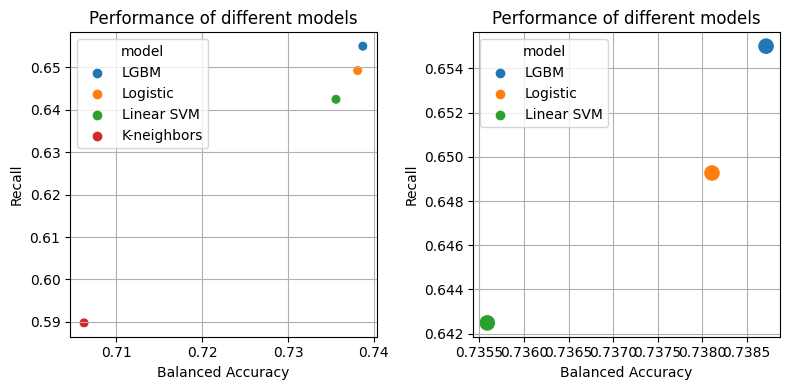

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4))
sns.scatterplot(
    results_df,
    x = "balanced_accuracy",
    y = "recall",
    hue = "model",
    s = 50,
    ax = axs[0]
)
sns.scatterplot(
    results_df.iloc[:-1, :],
    x = "balanced_accuracy",
    y = "recall",
    hue = "model",
    s = 150,
    ax = axs[1]
)
for i in range(2):
  axs[i].set_xlabel("Balanced Accuracy")
  axs[i].set_ylabel("Recall")
  axs[i].set_title("Performance of different models")
  axs[i].grid(True)
#axs[0].set_xlim(0.6, 0.77)
#axs[0].set_ylim(0.6, 0.77)
plt.tight_layout()
plt.savefig("scatterplot_models_2.pdf")
plt.show()


### 3.3 Models with features from Causality selection (Markov Blanket)

The method only works with numerical features, so we will need a workaround to change categorical features to numeric features.

In [ ]:
all_columns = X_train.columns.values
num_features_idx = [np.where(all_columns == col)[0][0] for col in num_features]
cat_features_idx = [np.where(all_columns == col)[0][0] for col in cat_features]

In [ ]:
def get_pipeline_preprocess():
  pipeline = [(
    "preprocess",
    ColumnTransformer([
        ["scaling", StandardScaler(), num_features],
        ["one_hot", OneHotEncoder(sparse_output = False, handle_unknown="ignore"), cat_features]
      ], remainder = "passthrough", verbose_feature_names_out=False)
  )]
  pipeline[0][1].set_output(transform = "pandas")
  return Pipeline(pipeline)

In [ ]:
if TRAIN_MODELS:
  pipeline_preprocess = get_pipeline_preprocess()
  pipeline_preprocess.fit(X_train, Y_train.values.ravel())
  X_train_preprocessed=pipeline_preprocess.transform(X_train)
  X_test_preprocessed=pipeline_preprocess.transform(X_test)

  ppi = PPIMBC(
      model=LogisticRegression(C = 100, max_iter = 1000),
      p_val_thresh=0.05,
      num_simul=15,
      simul_size=0.2,
      simul_type=0,
      sig_test_type="non-parametric",
      cv=0,
      random_state=0,
      n_jobs=-1,
      verbose=1
  )
  selected_samples = np.random.choice(X_train_preprocessed.shape[0], 1000)
  ppi.fit(
    X_train_preprocessed.iloc[selected_samples, :],
    Y_train.values.ravel()[selected_samples]
  )
  ppi.feature_importance()
  causal_features = ppi.MB
  causal_features_2 = []
  for feat in causal_features:
    if feat in num_features:
      causal_features_2.append(feat)
    elif feat in binary_features:
      causal_features_2.append(feat)
    else:
      clean_feat = "_".join(feat.split("_")[:-1])
      if clean_feat in cat_features:
        causal_features_2.append(clean_feat)
  causal_features_2 = list(set(causal_features_2))
else:
  causal_features_2 = ['TX_RESP_Q075',
  'TX_RESP_Q018',
  'TX_RESP_Q203',
  'TX_RESP_Q162',
  'TX_RESP_Q046',
  'TX_RESP_Q236',
  'TX_RESP_Q049',
  'TX_RESP_Q131',
  'TX_RESP_Q163',
  'TX_RESP_Q166',
  'TX_RESP_Q167',
  'TX_RESP_Q001',
  'TX_RESP_Q133',
  'TX_RESP_Q115',
  'NU_PRESENTES_9EF',
  'TX_RESP_Q112',
  'TX_RESP_Q078',
  'TX_RESP_Q181',
  'TX_RESP_Q165',
  'TX_RESP_Q200',
  'NU_MATRICULADOS_CENSO_9EF',
  'TX_RESP_Q134',
  'TX_RESP_Q160',
  'TX_RESP_Q225',
  'TX_RESP_Q101',
  'TX_RESP_Q082',
  'TX_RESP_Q091',
  'TX_RESP_Q108',
  'NIVEL_SOCIO_ECONOMICO',
  'TX_RESP_Q201',
  'TX_RESP_Q035',
  'TX_RESP_Q016',
  'ID_REGIAO',
  'TX_RESP_Q250',
  'TX_RESP_Q155',
  'TX_RESP_Q056',
  'TX_RESP_Q137',
  'TX_RESP_Q153',
  'TX_RESP_Q151',
  'TX_RESP_Q038',
  'TX_RESP_Q164',
  'TX_RESP_Q210',
  'TX_RESP_Q243',
  'TX_RESP_Q118',
  'PC_FORMACAO_DOCENTE_FINAL',
  'TX_RESP_Q053',
  'TX_RESP_Q158',
  'ID_UF',
  'TX_RESP_Q117',
  'TX_RESP_Q063']

In [ ]:
num_features_subset_2 = num_features.copy()
num_features_subset_2 = [col for col in num_features_subset_2 if col in causal_features_2]
binary_features_subset_2 = binary_features.copy()
binary_features_subset_2 = [col for col in binary_features_subset_2 if col in causal_features_2]
cat_features_subset_2 = cat_features.copy()
cat_features_subset_2 = [col for col in cat_features_subset_2 if col in causal_features_2]

In [ ]:
def get_pipeline_subset_2(model = None):
  pipeline = [(
    "preprocess",
    ColumnTransformer([
        ["scaling", StandardScaler(), num_features_subset_2],
        ["one_hot", OneHotEncoder(sparse_output = False, handle_unknown="ignore"), cat_features_subset_2]
      ], remainder = "passthrough", verbose_feature_names_out=False)
  )]
  pipeline[0][1].set_output(transform = "pandas")
  if model is not None:
    pipeline += [("classifier", model())]
  return Pipeline(pipeline)

In [ ]:
X_train_causal = X_train[causal_features_2]
X_test_causal = X_test[causal_features_2]

In [ ]:
X_train_causal.to_csv(PATH_ROOT + "data/X_train_causal.csv", index = False)
X_test_causal.to_csv(PATH_ROOT + "data/X_test_causal.csv", index = False)

In [ ]:
X_train_causal = pd.read_csv(PATH_ROOT + "data/X_train_causal.csv")
X_test_causal = pd.read_csv(PATH_ROOT + "data/X_test_causal.csv")

In [ ]:
classifiers_fit = {}
if TRAIN_MODELS:
  for name, model in classifiers.items():
    start = time()
    m = get_pipeline_subset_2(model)
    grid = GridSearchCV(m, params_space[name], scoring = "recall", n_jobs = -1)
    grid.fit(X_train_causal, Y_train.values.ravel())
    pkl.dump(grid, open(PATH_ROOT + "results/" + name + "_causal_feature_selection_grid.pkl", "wb"))
    end = time()
    print(f"Finished {name} in {end - start}")
    classifiers_fit[name] = grid
else:
  for name, model in classifiers.items():
    classifiers_fit[name] = pkl.load(open(PATH_ROOT + "results/" + name + "_causal_feature_selection_grid.pkl", "rb"))

In [ ]:
results_df = []
better_names = {
    "lr" : "Logistic",
    "knn" : "K-neighbors",
    "svm" : "Linear SVM",
    "lgbm" : "LGBM"
}
for name, model in classifiers_fit.items():
  Y_pred = model.predict(X_test_causal)
  results_df.append({
      "model" : better_names[name],
      "balanced_accuracy" : balanced_accuracy_score(Y_test, Y_pred),
      "recall" : recall_score(Y_test, Y_pred),
  })

results_df = pd.DataFrame(results_df)
results_df = results_df.iloc[::-1].reset_index(drop = True)

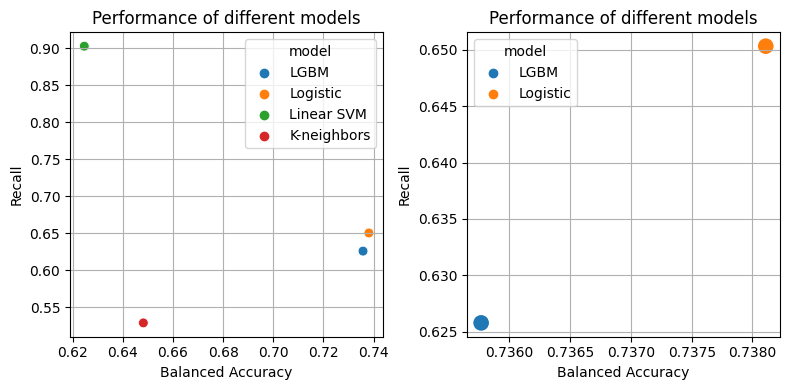

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4))
sns.scatterplot(
    results_df,
    x = "balanced_accuracy",
    y = "recall",
    hue = "model",
    s = 50,
    ax = axs[0]
)
sns.scatterplot(
    results_df.iloc[:-2, :],
    x = "balanced_accuracy",
    y = "recall",
    hue = "model",
    s = 150,
    ax = axs[1]
)
for i in range(2):
  axs[i].set_xlabel("Balanced Accuracy")
  axs[i].set_ylabel("Recall")
  axs[i].set_title("Performance of different models")
  axs[i].grid(True)
#axs[0].set_xlim(0.6, 0.77)
#axs[0].set_ylim(0.6, 0.77)
plt.tight_layout()
plt.savefig("scatterplot_models_3.pdf")
plt.show()


### 3.4 Model with Bayesian risk and Calibration


#### 3.3.1 Bayesian Risk

In [ ]:
X_train_causal = pd.read_csv(PATH_ROOT + "data/X_train_causal.csv")
X_test_causal = pd.read_csv(PATH_ROOT + "data/X_test_causal.csv")
studied_model = pkl.load(open(PATH_ROOT + "results/lr_causal_feature_selection_grid.pkl", "rb"))

In [ ]:
y_prob = studied_model.predict_proba(X_train_causal)[:, 1]
y_prob_test = studied_model.predict_proba(X_test_causal)[:, 1]

In [ ]:
original_confusion_matrix = confusion_matrix(Y_test, studied_model.predict(X_test))

In [ ]:
false_negative_cost = 1
false_positive_cost = 1.5

best_risk = float("inf")
best_threshold = 0.5

for threshold in range(0, 101):
    threshold /= 100.0
    y_pred = y_prob > threshold

    conf_matrix = confusion_matrix(Y_train, y_pred)
    true_positives, false_negatives, false_positives, true_negatives = conf_matrix.ravel()

    bayesian_risk = (false_negative_cost * (false_negatives / (false_negatives + true_positives)) +
                     false_positive_cost * (false_positives / (false_positives + true_negatives)))

    if bayesian_risk < best_risk:
        best_risk = bayesian_risk
        best_threshold = threshold

y_pred_test = y_prob_test > best_threshold
conf_matrix = confusion_matrix(Y_test, y_pred_test)
bal_acc = balanced_accuracy_score(Y_test, y_pred_test)
rec = recall_score(Y_test, y_pred_test)
print("Confusion matrix")
print(conf_matrix)

print(f"Best threshold: {best_threshold}")
print(f"Min Bayes Risk: {best_risk}")
print(f"New balanced accuracy: {bal_acc:.2f}")
print(f"New recall: {rec:.2f}")

Confusion matrix
[[1840 1032]
 [ 322 1594]]
Best threshold: 0.29
Min Bayes Risk: 0.5889170774674687
New balanced accuracy: 0.74
New recall: 0.83


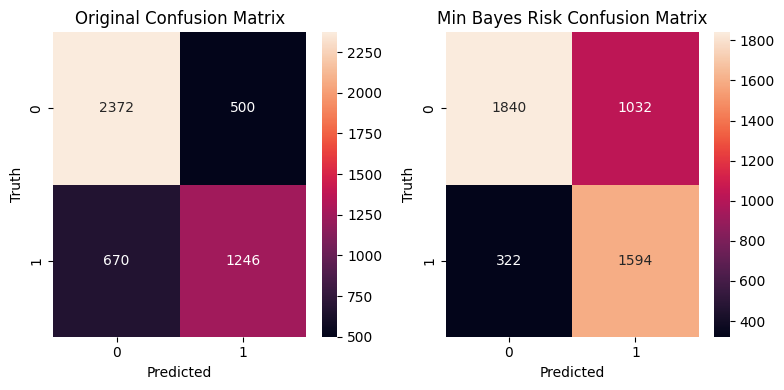

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
sns.heatmap(original_confusion_matrix, annot=True, fmt='.10g', ax = axs[0])
sns.heatmap(conf_matrix, annot=True, fmt='.10g', ax = axs[1])
axs[0].set_title("Original Confusion Matrix")
axs[1].set_title("Min Bayes Risk Confusion Matrix")

for i in range(2):
  axs[i].set_xlabel("Predicted")
  axs[i].set_ylabel("Truth")
plt.tight_layout()
plt.savefig("bayes_risk_cm.pdf")

#### 3.3.2 Calibration


In [ ]:
y_prob_train = studied_model.predict_proba(X_train_causal)[:, 1]

In [ ]:
brier_train = brier_score_loss(Y_train, y_prob_train)
print(f"Brier Score (Train): {brier_train}")

Brier Score (Train): 0.1577030997482427


In [ ]:
prob_true_train, prob_pred_train = calibration_curve(Y_train, y_prob_train, n_bins=10)

In [ ]:
plt.plot(prob_pred_train, prob_true_train, marker='o', label='Calibration Curve (Train)')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve (Train)')
plt.legend()
plt.gca().set_aspect('equal')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

NameError: ignored

## Model analysis

In [ ]:
Y_pred_test = studied_model.predict(X_test_causal)
rec_nivel = []
bal_acc_nivel = []
y_mean = []
y_hat_mean = []
for c in ['nivel-i',  'nivel-ii', 'nivel-iii', 'nivel-iv', 'nivel-v', 'nivel-vi', 'nivel-vii']:
  b = X_test_causal.NIVEL_SOCIO_ECONOMICO == c
  rec_nivel.append(recall_score(Y_test[b], Y_pred_test[b]))
  bal_acc_nivel.append(balanced_accuracy_score(Y_test[b], Y_pred_test[b]))
  y_mean.append(Y_test[b].mean())
  y_hat_mean.append(Y_pred_test[b].mean())

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import precision_score, roc_auc_score

In [ ]:
for name, y, x in [("Train", Y_train, X_train_causal), ("Test", Y_test, X_test_causal)]:
  print(name)
  print(f"ROC: {roc_auc_score(y, studied_model.predict_proba(x)[:, 1]):.2f}")
  print(f"Balanced accuracy: {balanced_accuracy_score(y, studied_model.predict(x)):.2f}")
  print(f"Recall score: {recall_score(y, studied_model.predict(x)):.2f}")
  print(f"Precision score: {precision_score(y, studied_model.predict(x)):.2f}")

Train
ROC: 0.84
Balanced accuracy: 0.75
Recall score: 0.66
Precision score: 0.73
Test
ROC: 0.82
Balanced accuracy: 0.74
Recall score: 0.65
Precision score: 0.71


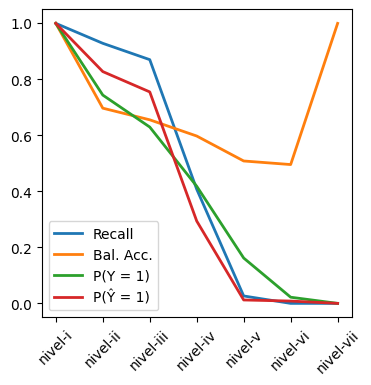

In [ ]:
fig = plt.subplots(figsize = (4, 4))
plt.plot(np.arange(len(rec_nivel)), rec_nivel, label = "Recall", lw = 2)
plt.plot(np.arange(len(rec_nivel)), bal_acc_nivel, label =  "Bal. Acc.", lw = 2)
plt.plot(np.arange(len(rec_nivel)), y_mean, label = "P(Y = 1)", lw = 2)
plt.plot(np.arange(len(rec_nivel)), y_hat_mean, label = "P(Ŷ = 1)", lw = 2)
plt.xticks(np.arange(len(rec_nivel)), labels = ['nivel-i',  'nivel-ii', 'nivel-iii', 'nivel-iv', 'nivel-v', 'nivel-vi', 'nivel-vii'], rotation = 45)
plt.legend()
plt.show()

In [ ]:
r = permutation_importance(studied_model, X_test_causal, Y_test, n_repeats=30, random_state=0)

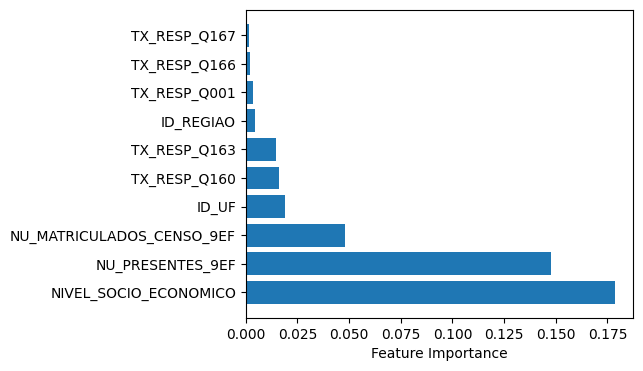

In [ ]:
plt.subplots(figsize = (5, 4))
importances = r["importances_mean"]
importances_sorted_idx = np.argsort(-importances)[:10]
plt.barh(np.arange(10), importances[importances_sorted_idx])
plt.yticks(np.arange(10), X_train_causal.columns.values[importances_sorted_idx])
plt.xlabel("Feature Importance")
plt.show()


In [ ]:
questions_dict = {'TX_RESP_Q001': 'Qual é a sua cor ou raça?\t',
 'TX_RESP_Q002': 'Por quanto tempo você trabalhou como professor(a) antes de se tornar diretor(a)? Anos (Regra de Validação: Q002 >= 0 e Q002 <= 35)',
 'TX_RESP_Q003': 'Por quanto tempo você trabalhou como professor(a) antes de se tornar diretor(a)? Meses  (Regra de Validação: Q003 >= 0 e Q003 <= 12)',
 'TX_RESP_Q004': 'Você possui quanto tempo de experiência como diretor(a) de escola? Anos (Regra de Validação: Q004 >= 0 e Q004 <= 35)',
 'TX_RESP_Q005': 'Você possui quanto tempo de experiência como diretor(a) de escola? Meses (Regra de Validação: Q005 >= 0 e Q005 <= 12)',
 'TX_RESP_Q006': 'Há quanto tempo você é diretor(a) desta escola? Anos (Regra de Validação: Q006 >= 0 e Q006 <= 35)',
 'TX_RESP_Q007': 'Há quanto tempo você é diretor(a) desta escola? Meses (Regra de Validação: Q007 >= 0 e Q007 <= 12)',
 'TX_RESP_Q008': 'Considerando todas as suas atividades profissionais remuneradas, quantas horas você trabalha em uma semana normal? (Regra de Validação: Q008 >= 0 e Q008 <= 70)',
 'TX_RESP_Q009': 'Quantas horas você trabalha em uma semana normal em atividades relacionadas à educação?(Regra de Validação: Q009 >= 0 e Q009 <= 70)',
 'TX_RESP_Q010': 'Na semana normal de trabalho, quantas horas você trabalha para esta escola?(Regra de Validação: Q010 >= 0 e Q010 <= 70)',
 'TX_RESP_Q011': 'Em uma semana normal de trabalho, quantas horas você costuma gastar, aproximadamente, com as seguintes atividades para esta escola: Prestação de contas (Regra de Validação: Q011 >= 0 e Q011 <= 30)',
 'TX_RESP_Q012': 'Em uma semana normal de trabalho, quantas horas você costuma gastar, aproximadamente, com as seguintes atividades para esta escola: Reunião com professores(as) (Regra de Validação: Q012 >= 0 e Q012 <= 20)',
 'TX_RESP_Q013': 'Em uma semana normal de trabalho, quantas horas você costuma gastar, aproximadamente, com as seguintes atividades para esta escola: Atendimento aos pais ou responsáveis (Regra de Validação: Q013 >= 0 e Q013 <= 30)',
 'TX_RESP_Q014': 'Em uma semana normal de trabalho, quantas horas você costuma gastar, aproximadamente, com as seguintes atividades para esta escola: Gerenciamento de conflitos (Regra de Validação: Q014 >= 0 e Q014 <= 30)',
 'TX_RESP_Q015': 'Em uma semana normal de trabalho, quantas horas você costuma gastar, aproximadamente, com as seguintes atividades para esta escola: Atendimento aos(às) alunos(as) (Regra de Validação: Q015 >= 0 e Q015 <= 30)',
 'TX_RESP_Q016': 'Em uma semana normal de trabalho, quantas horas você costuma gastar, aproximadamente, com as seguintes atividades para esta escola: Atendimento individual aos(às) professores(as) (Regra de Validação: Q016 >= 0 e Q016 <= 30)',
 'TX_RESP_Q017': 'Em uma semana normal de trabalho, quantas horas você costuma gastar, aproximadamente, com as seguintes atividades para esta escola: Demandas da Secretaria de Educação (Regra de Validação: Q017 >= 0 e Q017 <= 30)',
 'TX_RESP_Q018': 'Em uma semana normal de trabalho, quantas horas você costuma gastar, aproximadamente, com as seguintes atividades para esta escola: Merenda (Regra de Validação: Q018 >= 0 e Q018 <= 30)',
 'TX_RESP_Q019': 'Em uma semana normal de trabalho, quantas horas você costuma gastar, aproximadamente, com as seguintes atividades para esta escola: Manutenção (Regra de Validação: Q019 >= 0 e Q019 <= 30)',
 'TX_RESP_Q020': 'Em uma semana normal de trabalho, quantas horas você costuma gastar, aproximadamente, com as seguintes atividades para esta escola: Segurança (Regra de Validação: Q020 >= 0 e Q020 <= 30)',
 'TX_RESP_Q021': 'Em uma semana normal de trabalho, quantas horas você costuma gastar, aproximadamente, com as seguintes atividades para esta escola: Outras atividades (Regra de Validação: Q021 >= 0 e Q021 <= 30)',
 'TX_RESP_Q022': 'Quanto você sente estar preparado(a) para realizar a seguinte atividade: Liderar a equipe escolar.',
 'TX_RESP_Q023': 'Quanto você sente estar preparado(a) para realizar a seguinte atividade: Atender as demandas administrativas da rede escolar.',
 'TX_RESP_Q024': 'Quanto você sente estar preparado(a) para realizar a seguinte atividade: Atender as demandas administrativas da escola.',
 'TX_RESP_Q025': 'Quanto você sente estar preparado(a) para realizar a seguinte atividade: Garantir a manutenção da escola.',
 'TX_RESP_Q026': 'Quanto você sente estar preparado(a) para realizar a seguinte atividade: Resolver as demandas dos familiares dos(as) alunos(as).',
 'TX_RESP_Q027': 'Quanto você sente estar preparado(a) para realizar a seguinte atividade: Mobilizar a comunidade para auxiliar a escola.',
 'TX_RESP_Q028': 'Quanto você sente estar preparado(a) para realizar a seguinte atividade: Coordenar a implantação do Projeto Político-Pedagógico.',
 'TX_RESP_Q029': 'Quanto você sente estar preparado(a) para realizar a seguinte atividade: Administrar conflitos.',
 'TX_RESP_Q030': 'Quanto você sente estar preparado(a) para realizar a seguinte atividade: Manter os(as) professores(as) motivados(as).',
 'TX_RESP_Q031': 'Quanto você sente estar preparado(a) para realizar a seguinte atividade: Avaliar o desempenho dos(as) professores(as).',
 'TX_RESP_Q032': 'Quanto você sente estar preparado(a) para realizar a seguinte atividade: Realizar a autoavaliação institucional.',
 'TX_RESP_Q033': 'Quanto você sente estar preparado(a) para realizar a seguinte atividade: Melhorar os processos pedagógicos da sua escola.',
 'TX_RESP_Q034': 'Indique quais são as etapas educacionais atendidas pela sua escola: Educação Infantil e Creche (0 a 3 anos).',
 'TX_RESP_Q035': 'Indique quais são as etapas educacionais atendidas pela sua escola: Educação Infantil e Pré-escola (4 e 5 anos).',
 'TX_RESP_Q036': 'Indique quais são as etapas educacionais atendidas pela sua escola: Anos Iniciais do Ensino Fundamental.',
 'TX_RESP_Q037': 'Indique quais são as etapas educacionais atendidas pela sua escola: Anos Finais do Ensino Fundamental.',
 'TX_RESP_Q038': 'Indique quais são as etapas educacionais atendidas pela sua escola: Ensino Médio.',
 'TX_RESP_Q039': 'A educação infantil funciona na sede da escola? (Regra de Dependência: somente poderá ser preenchida caso Q034 ou Q035 seja igual a "A")',
 'TX_RESP_Q040': 'A área externa (pátio, área verde e parque) é utilizada em horários diferenciados pelos(as) alunos(as) da Educação Infantil? (Regra de Dependência: somente poderá ser preenchida caso Q034 ou Q035 seja igual a "A")',
 'TX_RESP_Q041': 'Indique o quanto concorda ou discorda das afirmativas relativas às condições de funcionamento desta escola neste ano: Os recursos financeiros foram suficientes.',
 'TX_RESP_Q042': 'Indique o quanto concorda ou discorda das afirmativas relativas às condições de funcionamento desta escola neste ano: Havia professores(as) para todas as disciplinas.',
 'TX_RESP_Q043': 'Indique o quanto concorda ou discorda das afirmativas relativas às condições de funcionamento desta escola neste ano: Havia quantidade suficiente de pessoal administrativo.',
 'TX_RESP_Q044': 'Indique o quanto concorda ou discorda das afirmativas relativas às condições de funcionamento desta escola neste ano: Havia quantidade suficiente de pessoal para apoio pedagógico (coordenador, orientador etc.).',
 'TX_RESP_Q045': 'Indique o quanto concorda ou discorda das afirmativas relativas às condições de funcionamento desta escola neste ano: Os recursos pedagógicos foram suficientes.',
 'TX_RESP_Q046': 'Indique o quanto concorda ou discorda das afirmativas relativas às condições de funcionamento desta escola neste ano: Recebi apoio da Secretaria de Educação.',
 'TX_RESP_Q047': 'Indique o quanto concorda ou discorda das afirmativas relativas às condições de funcionamento desta escola neste ano: Os(As) professores(as) foram assíduos(as).',
 'TX_RESP_Q048': 'Indique o quanto concorda ou discorda das afirmativas relativas às condições de funcionamento desta escola neste ano: Os(As) professores(as) iniciaram as aulas no horário marcado.',
 'TX_RESP_Q049': 'Indique o quanto concorda ou discorda das afirmativas relativas às condições de funcionamento desta escola neste ano: As substituições das ausências de professores(as) foram facilmente realizadas.',
 'TX_RESP_Q050': 'Indique o quanto concorda ou discorda das afirmativas relativas às condições de funcionamento desta escola neste ano: Os(As) alunos(as) foram assíduos(as).',
 'TX_RESP_Q051': 'Indique o quanto concorda ou discorda das afirmativas relativas às condições de funcionamento desta escola neste ano: Troquei experiências com diretores(as) de outras escolas.',
 'TX_RESP_Q052': 'Indique o quanto concorda ou discorda das afirmativas relativas às condições de funcionamento desta escola neste ano: A comunidade apoiou a gestão da escola.',
 'TX_RESP_Q053': 'Indique o quanto concorda ou discorda das afirmativas relativas às condições de funcionamento desta escola neste ano: A comunidade executou trabalhos voluntários na escola.',
 'TX_RESP_Q054': 'Indique o quanto concorda ou discorda das afirmativas relativas às condições de funcionamento desta escola neste ano: As famílias contribuíram com o trabalho pedagógico.',
 'TX_RESP_Q055': 'Os livros didáticos foram entregues antes do início das aulas (Regra de Dependência: somente poderá ser preenchida caso Q036, Q037 ou Q038 seja diferente de "B").',
 'TX_RESP_Q056': 'Todos(as) os(as) alunos(as) receberam livros didáticos (Regra de Dependência: somente poderá ser preenchida caso Q036, Q037 ou Q038 seja diferente de "B").',
 'TX_RESP_Q057': 'O calendário escolar pré-estabelecido foi cumprido sem interrupções?',
 'TX_RESP_Q058': 'Qual o motivo da interrupção do calendário? Falta de água (Regra de Dependência: somente será preenchida caso Q057 seja igual a "B")',
 'TX_RESP_Q059': 'Qual o motivo da interrupção do calendário? Falta de energia (Regra de Dependência: somente será preenchida caso Q057 seja igual a "B")',
 'TX_RESP_Q060': 'Qual o motivo da interrupção do calendário? Falta de merenda (Regra de Dependência: somente será preenchida caso Q057 seja igual a "B")',
 'TX_RESP_Q061': 'Qual o motivo da interrupção do calendário? Greve de professores (Regra de Dependência: somente será preenchida caso Q057 seja igual a "B")',
 'TX_RESP_Q062': 'Qual o motivo da interrupção do calendário? Vandalismo nas instalações (Regra de Dependência: somente será preenchida caso Q057 seja igual a "B")',
 'TX_RESP_Q063': 'Qual o motivo da interrupção do calendário? Problemas de infraestrutura da escola (Regra de Dependência: somente será preenchida caso Q057 seja igual a "B")',
 'TX_RESP_Q064': 'Qual o motivo da interrupção do calendário? Eventos externos (paralisação, bloqueio etc) (Regra de Dependência: somente será preenchida caso Q057 seja igual a "B")',
 'TX_RESP_Q065': 'Qual o motivo da interrupção do calendário? Eventos climáticos (inundação, desmoronamento etc) (Regra de Dependência: somente será preenchida caso Q057 seja igual a "B")',
 'TX_RESP_Q066': 'Qual o motivo da interrupção do calendário? Outros (Regra de Dependência: somente será preenchida caso Q057 seja igual a "B")',
 'TX_RESP_Q067': 'Por quantos dias ocorreu a interrupção: (Regra de Dependência: somente será preenchida caso Q057 seja igual a "B")',
 'TX_RESP_Q068': 'Sobre os fatos listados abaixo, diga a frequência com que ocorreram neste ano, nesta escola: Profissionais foram vítimas de atentado à vida (Regra de Dependência: somente poderá ser preenchida caso Q036, Q037 ou Q038 seja igual a "A").',
 'TX_RESP_Q069': 'Sobre os fatos listados abaixo, diga a frequência com que ocorreram neste ano, nesta escola: Profissionais foram ameaçados(as) por algum aluno (Regra de Dependência: somente poderá ser preenchida caso Q036, Q037 ou Q038 seja igual a "A").',
 'TX_RESP_Q070': 'Sobre os fatos listados abaixo, diga a frequência com que ocorreram neste ano, nesta escola: Houve ocorrência de roubo com uso de violência (Regra de Dependência: somente poderá ser preenchida caso Q036, Q037 ou Q038 seja igual a "A").',
 'TX_RESP_Q071': 'Sobre os fatos listados abaixo, diga a frequência com que ocorreram neste ano, nesta escola: Houve tráfico de drogas na escola (Regra de Dependência: somente poderá ser preenchida caso Q036, Q037 ou Q038 seja igual a "A").',
 'TX_RESP_Q072': 'Sobre os fatos listados abaixo, diga a frequência com que ocorreram neste ano, nesta escola: Alunos(as) frequentaram a escola sob efeito de bebida alcoólica (Regra de Dependência: somente poderá ser preenchida caso Q036, Q037 ou Q038 seja igual a "A").',
 'TX_RESP_Q073': 'Sobre os fatos listados abaixo, diga a frequência com que ocorreram neste ano, nesta escola: Alunos(as) frequentaram a escola sob efeito de drogas ilícitas (Regra de Dependência: somente poderá ser preenchida caso Q036, Q037 ou Q038 seja igual a "A").',
 'TX_RESP_Q074': 'Sobre os fatos listados abaixo, diga a frequência com que ocorreram neste ano, nesta escola: Alunos(as) frequentaram a escola portando arma (revólver, faca, canivete etc.) (Regra de Dependência: somente poderá ser preenchida caso Q036, Q037 ou Q038 seja igual a "A").',
 'TX_RESP_Q075': 'Sobre os fatos listados abaixo, diga a frequência com que ocorreram neste ano, nesta escola: Episódios de violência ocasionaram cancelamento das aulas (Regra de Dependência: somente poderá ser preenchida caso Q036, Q037 ou Q038 seja igual a "A").',
 'TX_RESP_Q076': 'Há na escola espaço destinado exclusivamente à amamentação? (Regra de Dependência: somente será preenchida caso Q034 seja igual a "A")',
 'TX_RESP_Q077': 'Há na escola local para armazenamento de leite materno? (Regra de Dependência: somente será preenchida caso Q034 seja igual a "A")',
 'TX_RESP_Q078': 'Há na escola banheiro com chuveiro para uso das crianças? (Regra de Dependência: somente será preenchida caso Q034 ou Q035 seja igual a "A")',
 'TX_RESP_Q079': 'Sobre a área externa da sua escola (pátio, parque e área verde), indique os itens existentes: Bebedouro ao alcance das crianças (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q080': 'Sobre a área externa da sua escola (pátio, parque e área verde), indique os itens existentes: Banheiro infantil (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q081': 'Sobre a área externa da sua escola (pátio, parque e área verde), indique os itens existentes: Área sombreada (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q082': 'Sobre a área externa da sua escola (pátio, parque e área verde), indique os itens existentes: Área coberta (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q083': 'Sobre a área externa da sua escola (pátio, parque e área verde), indique os itens existentes: Vegetação e jardim (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q084': 'Sobre a área externa da sua escola (pátio, parque e área verde), indique os itens existentes: Horta (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q085': 'Quais os tipos de solo ou revestimento do solo da área externa da sua escola? Piso emborrachado (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q086': 'Quais os tipos de solo ou revestimento do solo da área externa da sua escola? Cimento liso (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q087': 'Quais os tipos de solo ou revestimento do solo da área externa da sua escola? Cimento áspero (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q088': 'Quais os tipos de solo ou revestimento do solo da área externa da sua escola? Areia (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q089': 'Quais os tipos de solo ou revestimento do solo da área externa da sua escola? Grama (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q090': 'Quais os tipos de solo ou revestimento do solo da área externa da sua escola? Terra (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q091': 'Quais os tipos de solo ou revestimento do solo da área externa da sua escola? Cerâmica (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q092': 'Quais os tipos de solo ou revestimento do solo da área externa da sua escola? Pedras (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q093': 'Quais equipamentos existem nas áreas externas de recreação da sua escola? Tanque de areia (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q094': 'Quais equipamentos existem nas áreas externas de recreação da sua escola? Gira-gira (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q095': 'Quais equipamentos existem nas áreas externas de recreação da sua escola? Túnel lúdico (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q096': 'Quais equipamentos existem nas áreas externas de recreação da sua escola? Gangorra (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q097': 'Quais equipamentos existem nas áreas externas de recreação da sua escola? Escorregador (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q098': 'Quais equipamentos existem nas áreas externas de recreação da sua escola? Casinha (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q099': 'Quais equipamentos existem nas áreas externas de recreação da sua escola? Balanço (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q100': 'Quais equipamentos existem nas áreas externas de recreação da sua escola? Brinquedo para escalar (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q101': 'Quais equipamentos existem nas áreas externas de recreação da sua escola? Banco (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q102': 'Quais equipamentos existem nas áreas externas de recreação da sua escola? Outros (Regra de Dependência: somente será preenchida caso Q034, Q035 ou Q036 seja igual a "A")',
 'TX_RESP_Q103': 'Avalie os seguintes aspectos da escola: Condições de uso dos equipamentos da área externa de recreação.',
 'TX_RESP_Q104': 'Avalie os seguintes aspectos da escola: O acesso à área externa de recreação pelos(as) alunos(as) público-alvo da educação especial.',
 'TX_RESP_Q105': 'Avalie os seguintes aspectos da escola: O acesso à entrada principal das pessoas com deficiência física e visual (ex.: rampas e marcadores no chão).',
 'TX_RESP_Q106': 'Avalie os seguintes aspectos da escola: Segurança na entrada e saída dos(as) alunos(as) da escola.',
 'TX_RESP_Q107': 'Avalie os seguintes aspectos da escola: Muros e grades que impedem que os(as) alunos(as) saiam sozinhos(as).',
 'TX_RESP_Q108': 'Avalie os seguintes aspectos da escola: Identificação externa que caracterize o prédio como uma instituição escolar.',
 'TX_RESP_Q109': 'Como a escola adquire Brinquedos: Compra realizada pela própria escola/Secretaria de Educação (Regra de Dependência: somente será preenchida caso Q034 ou Q035 seja igual a "A)',
 'TX_RESP_Q110': 'Como a escola adquire Brinquedos: Doações e campanhas de arrecadação (Regra de Dependência: somente será preenchida caso Q034 ou Q035 seja igual a "A)',
 'TX_RESP_Q111': 'Como a escola adquire Brinquedos: Solicitado aos responsáveis pelas crianças (Regra de Dependência: somente será preenchida caso Q034 ou Q035 seja igual a "A)',
 'TX_RESP_Q112': 'Como a escola adquire Recursos pedagógicos: Compra realizada pela própria escola/Secretaria de Educação (Regra de Dependência: somente será preenchida caso Q034 ou Q035 seja igual a "A)',
 'TX_RESP_Q113': 'Como a escola adquire Recursos pedagógicos: Doações e campanhas de arrecadação (Regra de Dependência: somente será preenchida caso Q034 ou Q035 seja igual a "A)',
 'TX_RESP_Q114': 'Como a escola adquire Recursos pedagógicos: Solicitado aos responsáveis pelas crianças (Regra de Dependência: somente será preenchida caso Q034 ou Q035 seja igual a "A)',
 'TX_RESP_Q115': 'Como a escola adquire Materiais de higiene pessoal: Compra realizada pela própria escola/Secretaria de Educação (Regra de Dependência: somente será preenchida caso Q034 ou Q035 seja igual a "A)',
 'TX_RESP_Q116': 'Como a escola adquire Materiais de higiene pessoal: Doações e campanhas de arrecadação (Regra de Dependência: somente será preenchida caso Q034 ou Q035 seja igual a "A)',
 'TX_RESP_Q117': 'Como a escola adquire Materiais de higiene pessoal: Solicitado aos responsáveis pelas crianças (Regra de Dependência: somente será preenchida caso Q034 ou Q035 seja igual a "A)',
 'TX_RESP_Q118': 'O Conselho Escolar é um colegiado geralmente constituído por representantes da escola e da comunidade que tem como objetivo acompanhar as atividades escolares. Na sua escola existe Conselho Escolar?',
 'TX_RESP_Q119': 'Quantas reuniões do Conselho Escolar ocorreram neste ano? (Regra de Dependência: somente será preenchida caso Q118 seja igual a "A")',
 'TX_RESP_Q120': 'Considere os atores relacionados a seguir e indique quantos participam do Conselho Escolar: Professores(as) (Regra de Dependência: somente será preenchida caso Q118 seja igual a "A")',
 'TX_RESP_Q121': 'Considere os atores relacionados a seguir e indique quantos participam do Conselho Escolar: Alunos(as) (Regra de Dependência: somente será preenchida caso Q118 seja igual a "A")',
 'TX_RESP_Q122': 'Considere os atores relacionados a seguir e indique quantos participam do Conselho Escolar: Pais (ou responsáveis) (Regra de Dependência: somente será preenchida caso Q118 seja igual a "A")',
 'TX_RESP_Q123': 'Considere os atores relacionados a seguir e indique quantos participam do Conselho Escolar: Funcionários (Regra de Dependência: somente será preenchida caso Q118 seja igual a "A")',
 'TX_RESP_Q124': 'Considere os atores relacionados a seguir e indique quantos participam do Conselho Escolar: Outros membros (Regra de Dependência: somente será preenchida caso Q118 seja igual a "A")',
 'TX_RESP_Q125': 'Neste ano, indique a frequência com que os temas/assuntos foram discutidos pelo Conselho Escolar: Questões pedagógicas (Regra de Dependência: somente será preenchida caso Q118 seja igual a "A")',
 'TX_RESP_Q126': 'Neste ano, indique a frequência com que os temas/assuntos foram discutidos pelo Conselho Escolar: Questões administrativas e institucionais (Regra de Dependência: somente será preenchida caso Q118 seja igual a "A")',
 'TX_RESP_Q127': 'Neste ano, indique a frequência com que os temas/assuntos foram discutidos pelo Conselho Escolar: Questões financeiras (Regra de Dependência: somente será preenchida caso Q118 seja igual a "A")',
 'TX_RESP_Q128': 'Neste ano, indique a frequência com que os temas/assuntos foram discutidos pelo Conselho Escolar: Questões de relacionamento com a comunidade (Regra de Dependência: somente será preenchida caso Q118 seja igual a "A")',
 'TX_RESP_Q129': 'O Conselho Escolar tem função deliberativa? (Regra de Dependência: somente será preenchida caso Q118 seja igual a "A")',
 'TX_RESP_Q130': 'O Conselho de Classe é um órgão formado por todos os professores que lecionam em cada turma/ano. Neste ano e nesta escola, quantas vezes se reuniu o Conselho de Classe?',
 'TX_RESP_Q131': 'O Conselho de Classe é um órgão formado por todos os professores que lecionam em cada turma/ano. Neste ano e nesta escola, quantas vezes se reuniu o Conselho de Classe? Não existe Conselho',
 'TX_RESP_Q132': 'A APM - Associação de Pais e Mestres existe para apoiar as ações da escola e integrar a comunidade. Neste ano e nesta escola, quantas vezes se reuniu a APM (ou caixa escolar)?',
 'TX_RESP_Q133': 'A APM - Associação de Pais e Mestres existe para apoiar as ações da escola e integrar a comunidade. Neste ano e nesta escola, quantas vezes se reuniu a APM (ou caixa escolar)?  Não existe APM.',
 'TX_RESP_Q134': 'Há Grêmio Estudantil? (Regra de Dependência: somente será preenchida caso Q037 ou Q038 seja igual a  "A")',
 'TX_RESP_Q135': 'A escola é administrada pela Polícia Militar (Regra de Dependência: somente será preenchida caso Q035, Q036, Q037 ou Q038 seja igual a "A")',
 'TX_RESP_Q136': 'Os(As) estudantes são preparados(as) para os testes de avaliação externos. (Regra de Dependência: somente será preenchida caso Q035, Q036, Q037 ou Q038 seja igual a "A")',
 'TX_RESP_Q137': 'A escola segue orientação religiosa (Regra de Dependência: somente será preenchida caso Q035, Q036, Q037 ou Q038 seja igual a "A").',
 'TX_RESP_Q138': 'Indique se as fontes abaixo fornecem ou não fornecem recursos para o funcionamento desta escola: Programa Dinheiro Direto da Escola.',
 'TX_RESP_Q139': 'Indique se as fontes abaixo fornecem ou não fornecem recursos para o funcionamento desta escola: Eventos promovidos nas dependências da escola (Festas, rifas etc.).',
 'TX_RESP_Q140': 'Indique se as fontes abaixo fornecem ou não fornecem recursos para o funcionamento desta escola: Empresas que apoiam a escola.',
 'TX_RESP_Q141': 'Indique se as fontes abaixo fornecem ou não fornecem recursos para o funcionamento desta escola: Organizações sem fins lucrativos.',
 'TX_RESP_Q142': 'Indique se as fontes abaixo fornecem ou não fornecem recursos para o funcionamento desta escola: Repasses da rede de ensino.',
 'TX_RESP_Q143': 'Indique se as fontes abaixo fornecem ou não fornecem recursos para o funcionamento desta escola: Pagamento de taxas pelos familiares dos(as) estudantes.',
 'TX_RESP_Q144': 'Indique se as fontes abaixo fornecem ou não fornecem recursos para o funcionamento desta escola: Contribuições voluntárias dos familiares dos(as) estudantes.',
 'TX_RESP_Q145': 'Indique se as fontes abaixo fornecem ou não fornecem recursos para o funcionamento desta escola: Contribuições voluntárias dos(as) profissionais da escola.',
 'TX_RESP_Q146': 'A escola oferece merenda aos(às) estudantes?',
 'TX_RESP_Q147': 'Quantas refeições são oferecidas nesta escola para alunos(as) que permanecem menos de 4 horas na escola (Regra de Dependência: somente será preenchida caso Q146 seja igual a "A):',
 'TX_RESP_Q148': 'Quantas refeições são oferecidas nesta escola para alunos(as) que permanecem entre 4 e 7 horas na escola (Regra de Dependência: somente será preenchida caso Q146 seja igual a "A):',
 'TX_RESP_Q149': 'Quantas refeições são oferecidas nesta escola para alunos(as) que permanecem mais de 7 horas na escola (Regra de Dependência: somente será preenchida caso Q146 seja igual a "A):',
 'TX_RESP_Q150': 'A quantidade de alimentos é suficiente para todos(as) (Regra de Dependência: somente será preenchida caso Q146 seja igual a "A).',
 'TX_RESP_Q151': 'Os alimentos são de boa qualidade (Regra de Dependência: somente será preenchida caso Q146 seja igual a "A).',
 'TX_RESP_Q152': 'A cozinha atende todas as necessidades do preparo da merenda (Regra de Dependência: somente será preenchida caso Q146 seja igual a "A).',
 'TX_RESP_Q153': 'Todos(as) conseguem se alimentar sentados (Regra de Dependência: somente será preenchida caso Q146 seja igual a "A).',
 'TX_RESP_Q154': 'O acesso ao local de alimentação é livre para pessoas com mobilidade reduzida (Regra de Dependência: somente será preenchida caso Q146 seja igual a "A).',
 'TX_RESP_Q155': 'Há pias para higienização das mãos próximas ao local de alimentação (Regra de Dependência: somente será preenchida caso Q146 seja igual a "A).',
 'TX_RESP_Q156': 'A merenda escolar é preparada na própria instituição? (Regra de Dependência: somente será preenchida caso Q146 seja igual a "A)',
 'TX_RESP_Q157': 'Os cardápios da alimentação escolar são elaborados por nutricionista? (Regra de Dependência: somente será preenchida caso Q146 seja igual a "A)',
 'TX_RESP_Q158': 'A escola possui Projeto Político-Pedagógico?',
 'TX_RESP_Q159': 'Seu conteúdo é discutido em reuniões? (Regra de Dependência: somente será preenchida caso Q158 seja igual a "A")',
 'TX_RESP_Q160': 'Os(As) professores(as) participaram da elaboração? (Regra de Dependência: somente será preenchida caso Q158 seja igual a "A")',
 'TX_RESP_Q161': 'Os pais participaram da elaboração? (Regra de Dependência: somente será preenchida caso Q158 seja igual a "A")',
 'TX_RESP_Q162': 'Os(As) estudantes participaram da elaboração? (Regra de Dependência: somente será preenchida caso Q158 seja igual a "A")',
 'TX_RESP_Q163': 'Estabelece metas de aprendizagem? (Regra de Dependência: somente será preenchida caso Q158 seja igual a "A")',
 'TX_RESP_Q164': 'Considera os resultados de avaliações externas (Saeb, estaduais, municipais etc.)? (Regra de Dependência: somente será preenchida caso Q158 seja igual a "A")',
 'TX_RESP_Q165': 'Há metas de alcance de indicadores externos (Ideb, índices estaduais ou municipais)? (Regra de Dependência: somente será preenchida caso Q158 seja igual a "A")',
 'TX_RESP_Q166': 'Neste ano e nesta escola, todos que solicitaram vagas conseguiram se matricular?',
 'TX_RESP_Q167': 'Neste ano, quais foram os critérios para a matrícula de novos estudantes nesta escola: Sorteio (Regra de Dependência: somente será preenchida caso Q166 seja igual a "B")',
 'TX_RESP_Q168': 'Neste ano, quais foram os critérios para a matrícula de novos estudantes nesta escola: Local de moradia (Regra de Dependência: somente será preenchida caso Q166 seja igual a "B")',
 'TX_RESP_Q169': 'Neste ano, quais foram os critérios para a matrícula de novos estudantes nesta escola: Prova de seleção (Regra de Dependência: somente será preenchida caso Q166 seja igual a "B")',
 'TX_RESP_Q170': 'Neste ano, quais foram os critérios para a matrícula de novos estudantes nesta escola: Ordem de chegada (Regra de Dependência: somente será preenchida caso Q166 seja igual a "B")',
 'TX_RESP_Q171': 'Neste ano, quais foram os critérios para a matrícula de novos estudantes nesta escola: Cor ou raça do(a) estudante (Regra de Dependência: somente será preenchida caso Q166 seja igual a "B")',
 'TX_RESP_Q172': 'Neste ano, quais foram os critérios para a matrícula de novos estudantes nesta escola: Características socioeconômicas (Regra de Dependência: somente será preenchida caso Q166 seja igual a "B")',
 'TX_RESP_Q173': 'Neste ano, quais foram os critérios para a matrícula de novos estudantes nesta escola: Desempenho do(a) estudante no ano anterior (Regra de Dependência: somente será preenchida caso Q166 seja igual a "B")',
 'TX_RESP_Q174': 'Neste ano, quais foram os critérios para a matrícula de novos estudantes nesta escola: Outros (Regra de Dependência: somente será preenchida caso Q166 seja igual a "B")',
 'TX_RESP_Q175': 'Quais critérios foram considerados para a formação das turmas: Não se aplica',
 'TX_RESP_Q176': 'Quais critérios foram considerados para a formação das turmas: Afinidade entre os(as) estudantes',
 'TX_RESP_Q177': 'Quais critérios foram considerados para a formação das turmas: Agrupar os(as) estudantes segundo a idade',
 'TX_RESP_Q178': 'Quais critérios foram considerados para a formação das turmas: Equilíbrio de meninos e meninas nas turmas',
 'TX_RESP_Q179': 'Quais critérios foram considerados para a formação das turmas: Manter as turmas existentes do ano anterior',
 'TX_RESP_Q180': 'Quais critérios foram considerados para a formação das turmas: Agrupar os(as) estudantes por critérios disciplinares',
 'TX_RESP_Q181': 'Quais critérios foram considerados para a formação das turmas: Agrupar os(as) estudantes com base no seu desempenho',
 'TX_RESP_Q182': 'Quais critérios foram considerados para a formação das turmas: Outro',
 'TX_RESP_Q183': 'Neste ano, quais critérios foram utilizados para a atribuição das turmas aos(às) professores(as)? Preferência dos(as) professores(as).',
 'TX_RESP_Q184': 'Neste ano, quais critérios foram utilizados para a atribuição das turmas aos(às) professores(as)? Tempo de serviço.',
 'TX_RESP_Q185': 'Neste ano, quais critérios foram utilizados para a atribuição das turmas aos(às) professores(as)? Cursos de formação continuada realizados.',
 'TX_RESP_Q186': 'Neste ano, quais critérios foram utilizados para a atribuição das turmas aos(às) professores(as)? Professores(as) experientes nas turmas com facilidade de aprendizagem.',
 'TX_RESP_Q187': 'Neste ano, quais critérios foram utilizados para a atribuição das turmas aos(às) professores(as)? Professores(as) experientes nas turmas com dificuldade de aprendizagem.',
 'TX_RESP_Q188': 'Neste ano, quais critérios foram utilizados para a atribuição das turmas aos(às) professores(as)? Manutenção do(a) professor(a) com a mesma turma.',
 'TX_RESP_Q189': 'Neste ano, quais critérios foram utilizados para a atribuição das turmas aos(às) professores(as)? Revezamento dos(as) professores(as) entre séries/anos.',
 'TX_RESP_Q190': 'Neste ano, quais critérios foram utilizados para a atribuição das turmas aos(às) professores(as)? Sorteio das turmas entre os(as) professores(as).',
 'TX_RESP_Q191': 'Neste ano, quais critérios foram utilizados para a atribuição das turmas aos(às) professores(as)? Atribuição pela gestão da escola.',
 'TX_RESP_Q192': 'Na sua escola há parcerias com: Ministério Público',
 'TX_RESP_Q193': 'Na sua escola há parcerias com: Conselho Tutelar',
 'TX_RESP_Q194': 'Na sua escola há parcerias com: Secretaria de Saúde',
 'TX_RESP_Q195': 'Na sua escola há parcerias com: Secretaria de Educação',
 'TX_RESP_Q196': 'Na sua escola há parcerias com: Secretaria de Assistência Social',
 'TX_RESP_Q197': 'Na sua escola há parcerias com: Secretaria de Segurança Pública',
 'TX_RESP_Q198': 'Na sua escola há parcerias com: Organizações não governamentais/instituições privadas',
 'TX_RESP_Q199': 'Neste ano, para redução do ABANDONO ESCOLAR, avalie o resultado das seguintes ações realizadas nesta escola: Entrar em contato com os familiares do(a) estudante (Regra de Dependência: somente será preenchida caso Q035, Q036, Q037 ou Q038 seja igual a "A")',
 'TX_RESP_Q200': 'Neste ano, para redução do ABANDONO ESCOLAR, avalie o resultado das seguintes ações realizadas nesta escola: Ir à residência do(a) estudante (Regra de Dependência: somente será preenchida caso Q035, Q036, Q037 ou Q038 seja igual a "A")',
 'TX_RESP_Q201': 'Neste ano, para redução do ABANDONO ESCOLAR, avalie o resultado das seguintes ações realizadas nesta escola: Informar ao Conselho Tutelar (Regra de Dependência: somente será preenchida caso Q035, Q036, Q037 ou Q038 seja igual a "A")',
 'TX_RESP_Q202': 'Neste ano, para a redução da REPETÊNCIA ESCOLAR, avalie o resultado das seguintes ações realizadas nesta escola: Oferta de reforço escolar (Regra de Dependência: somente será preenchida caso Q036, Q037 ou Q038 seja igual a "A")',
 'TX_RESP_Q203': 'Neste ano, para a redução da REPETÊNCIA ESCOLAR, avalie o resultado das seguintes ações realizadas nesta escola: Os(As) estudantes são estimulados(as) a apoiar uns(umas) aos(às) outros(as) (Regra de Dependência: somente será preenchida caso Q036, Q037 ou Q038 seja igual a "A")',
 'TX_RESP_Q204': 'Neste ano, para a redução da REPETÊNCIA ESCOLAR, avalie o resultado das seguintes ações realizadas nesta escola: Revisão dos procedimentos de avaliação (Regra de Dependência: somente será preenchida caso Q036, Q037 ou Q038 seja igual a "A")',
 'TX_RESP_Q205': 'Neste ano, para a redução da REPETÊNCIA ESCOLAR, avalie o resultado das seguintes ações realizadas nesta escola: Revisão das práticas pedagógicas (Regra de Dependência: somente será preenchida caso Q036, Q037 ou Q038 seja igual a "A")',
 'TX_RESP_Q206': 'Nesta escola, há projetos com as seguintes temáticas: Violência',
 'TX_RESP_Q207': 'Nesta escola, há projetos com as seguintes temáticas: Bullying',
 'TX_RESP_Q208': 'Nesta escola, há projetos com as seguintes temáticas: Machismo',
 'TX_RESP_Q209': 'Nesta escola, há projetos com as seguintes temáticas: Homofobia',
 'TX_RESP_Q210': 'Nesta escola, há projetos com as seguintes temáticas: Sexualidade',
 'TX_RESP_Q211': 'Nesta escola, há projetos com as seguintes temáticas: Uso de drogas',
 'TX_RESP_Q212': 'Nesta escola, há projetos com as seguintes temáticas: Direitos dos idosos',
 'TX_RESP_Q213': 'Nesta escola, há projetos com as seguintes temáticas: Educação ambiental',
 'TX_RESP_Q214': 'Nesta escola, há projetos com as seguintes temáticas: Ciência e tecnologia',
 'TX_RESP_Q215': 'Nesta escola, há projetos com as seguintes temáticas: Diversidade religiosa',
 'TX_RESP_Q216': 'Nesta escola, há projetos com as seguintes temáticas: Desigualdades sociais',
 'TX_RESP_Q217': 'Nesta escola, há projetos com as seguintes temáticas: Nutrição e alimentação',
 'TX_RESP_Q218': 'Nesta escola, há projetos com as seguintes temáticas: Educação para o trânsito',
 'TX_RESP_Q219': 'Nesta escola, há projetos com as seguintes temáticas: Relações étnico-raciais/racismo',
 'TX_RESP_Q220': 'Nesta escola, há projetos com as seguintes temáticas: Direitos da criança e do adolescente',
 'TX_RESP_Q221': 'Nesta escola, há projetos com as seguintes temáticas: Mundo do trabalho (direitos, relações etc)',
 'TX_RESP_Q222': 'Nesta escola, há projetos com as seguintes temáticas: Educação financeira e consumo sustentável',
 'TX_RESP_Q223': 'Indique se neste ano a escola ofereceu atividades de formação nas seguintes áreas: Conteúdo e compreensão dos conceitos da(s) área(s) de ensino.',
 'TX_RESP_Q224': 'Indique se neste ano a escola ofereceu atividades de formação nas seguintes áreas: Avaliação da aprendizagem.',
 'TX_RESP_Q225': 'Indique se neste ano a escola ofereceu atividades de formação nas seguintes áreas: Avaliação em larga escala.',
 'TX_RESP_Q226': 'Indique se neste ano a escola ofereceu atividades de formação nas seguintes áreas: Metodologias de ensino.',
 'TX_RESP_Q227': 'Indique se neste ano a escola ofereceu atividades de formação nas seguintes áreas: Conhecimento do currículo.',
 'TX_RESP_Q228': 'Indique se neste ano a escola ofereceu atividades de formação nas seguintes áreas: Gestão da sala de aula.',
 'TX_RESP_Q229': 'Indique se neste ano a escola ofereceu atividades de formação nas seguintes áreas: Educação inclusiva.',
 'TX_RESP_Q230': 'Indique se neste ano a escola ofereceu atividades de formação nas seguintes áreas: Novas tecnologias.',
 'TX_RESP_Q231': 'Indique se neste ano a escola ofereceu atividades de formação nas seguintes áreas: Gestão e administração escolar.',
 'TX_RESP_Q232': 'Os(As) profissionais para inclusão do público-alvo da educação especial são em número suficiente?',
 'TX_RESP_Q233': 'Indique quais outros(as) profissionais seriam necessários(as) no momento: Professor(a) de Braille (Regra de Dependência: somente será preenchida caso Q232 seja igual a "B")',
 'TX_RESP_Q234': 'Indique quais outros(as) profissionais seriam necessários(as) no momento: Professor(a) de Educação Especial que atua na sala comum (Regra de Dependência: somente será preenchida caso Q232 seja igual a "B")',
 'TX_RESP_Q235': 'Indique quais outros(as) profissionais seriam necessários(as) no momento: Professor(a) bilíngue para surdos (Regra de Dependência: somente será preenchida caso Q232 seja igual a "B")',
 'TX_RESP_Q236': 'Indique quais outros(as) profissionais seriam necessários(as) no momento: Professor(a) de Libras (Regra de Dependência: somente será preenchida caso Q232 seja igual a "B")',
 'TX_RESP_Q237': 'Indique quais outros(as) profissionais seriam necessários(as) no momento: Professor(a) da sala de recursos multifuncionais (Regra de Dependência: somente será preenchida caso Q232 seja igual a "B")',
 'TX_RESP_Q238': 'Indique quais outros(as) profissionais seriam necessários(as) no momento: Professor(a) itinerante (Regra de Dependência: somente será preenchida caso Q232 seja igual a "B")',
 'TX_RESP_Q239': 'Indique quais outros(as) profissionais seriam necessários(as) no momento: Monitor(a) de apoio (Regra de Dependência: somente será preenchida caso Q232 seja igual a "B")',
 'TX_RESP_Q240': 'Indique quais outros(as) profissionais seriam necessários(as) no momento: Outros (Regra de Dependência: somente será preenchida caso Q232 seja igual a "B")',
 'TX_RESP_Q241': 'Nos últimos doze meses, sua escola recebeu treinamento para lidar com o público-alvo da educação especial?',
 'TX_RESP_Q242': 'Em quais áreas ocorreram treinamento: Deficiência intelectual (Regra de Dependência: somente será preenchida caso Q241 seja igual a "A")',
 'TX_RESP_Q243': 'Em quais áreas ocorreram treinamento: Deficiência física (Regra de Dependência: somente será preenchida caso Q241 seja igual a "A")',
 'TX_RESP_Q244': 'Em quais áreas ocorreram treinamento: Autismo ou outro Transtorno Global do Desenvolvimento (Regra de Dependência: somente será preenchida caso Q241 seja igual a "A")',
 'TX_RESP_Q245': 'Em quais áreas ocorreram treinamento: Surdez (Regra de Dependência: somente será preenchida caso Q241 seja igual a "A")',
 'TX_RESP_Q246': 'Em quais áreas ocorreram treinamento: Deficiência auditiva (Regra de Dependência: somente será preenchida caso Q241 seja igual a "A")',
 'TX_RESP_Q247': 'Em quais áreas ocorreram treinamento: Cegueira (Regra de Dependência: somente será preenchida caso Q241 seja igual a "A")',
 'TX_RESP_Q248': 'Em quais áreas ocorreram treinamento: Baixa visão (Regra de Dependência: somente será preenchida caso Q241 seja igual a "A")',
 'TX_RESP_Q249': 'Em quais áreas ocorreram treinamento: Deficiência múltipla (Regra de Dependência: somente será preenchida caso Q241 seja igual a "A")',
 'TX_RESP_Q250': 'Em quais áreas ocorreram treinamento: Altas habilidades/superdotação (Regra de Dependência: somente será preenchida caso Q241 seja igual a "A")',
 'TX_RESP_Q251': 'Em quais áreas ocorreram treinamento: Surdo-cegueira (Regra de Dependência: somente será preenchida caso Q241 seja igual a "A")',
 'TX_RESP_Q252': 'Sobre este questionário, avalie os tópicos a seguir: Facilidade de preenchimento das respostas.',
 'TX_RESP_Q253': 'Sobre este questionário, avalie os tópicos a seguir: Compreensão dos termos utilizados no questionário.'}

In [ ]:
for col in X_train_causal.columns:
  if col in questions_dict.keys():
    print(col, questions_dict[col])

TX_RESP_Q075 Sobre os fatos listados abaixo, diga a frequência com que ocorreram neste ano, nesta escola: Episódios de violência ocasionaram cancelamento das aulas (Regra de Dependência: somente poderá ser preenchida caso Q036, Q037 ou Q038 seja igual a "A").
TX_RESP_Q018 Em uma semana normal de trabalho, quantas horas você costuma gastar, aproximadamente, com as seguintes atividades para esta escola: Merenda (Regra de Validação: Q018 >= 0 e Q018 <= 30)
TX_RESP_Q203 Neste ano, para a redução da REPETÊNCIA ESCOLAR, avalie o resultado das seguintes ações realizadas nesta escola: Os(As) estudantes são estimulados(as) a apoiar uns(umas) aos(às) outros(as) (Regra de Dependência: somente será preenchida caso Q036, Q037 ou Q038 seja igual a "A")
TX_RESP_Q162 Os(As) estudantes participaram da elaboração? (Regra de Dependência: somente será preenchida caso Q158 seja igual a "A")
TX_RESP_Q046 Indique o quanto concorda ou discorda das afirmativas relativas às condições de funcionamento desta esco